In [41]:
import os
from PIL import Image
import pickle

import neat
import custom_neat
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from custom_neat.nn.recurrent import RNN

np.random.seed(1)

## Read in population checkpoints

In [2]:
CHECKPOINT_DIR = '16-12-19/'

In [3]:
populations = []
for filename in os.listdir(CHECKPOINT_DIR):
    population = neat.Checkpointer.restore_checkpoint(CHECKPOINT_DIR + filename)
    populations.append(population)
    
populations.sort(key=lambda x: x.generation)

## Explore data

### Global population

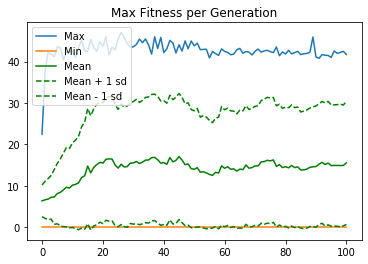

In [4]:
# Plot fitness per generation
fitnesses = []
for pop in populations:
    temp = []
    for genome in pop.population.values():
        temp.append(genome.fitness if genome.fitness else 0)
    fitnesses.append(temp)

best_fitnesses = [max(f) for f in fitnesses]
generations = [p.generation for p in populations]

plt.plot(generations, [max(f) for f in fitnesses], label='Max')
plt.plot(generations, [min(f) for f in fitnesses], label='Min')
plt.plot(generations, [np.mean(f) for f in fitnesses], label='Mean', color='g')
plt.plot(generations, [np.mean(f) + np.std(f) for f in fitnesses], label='Mean + 1 sd', linestyle='--', color='g')
plt.plot(generations, [np.mean(f) - np.std(f) for f in fitnesses], label='Mean - 1 sd', linestyle='--', color='g')
plt.title('Max Fitness per Generation')
plt.legend(loc='best')
plt.show()

### Speciation

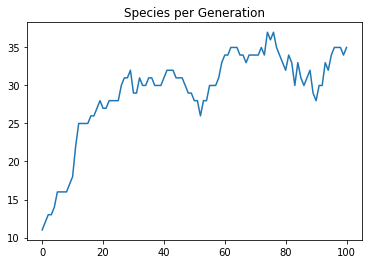

In [5]:
# Plot number of species per generation
n_species = [len(p.species.species) for p in populations]
generations = [p.generation for p in populations]

plt.plot(generations, n_species)
plt.title('Species per Generation')
plt.show()

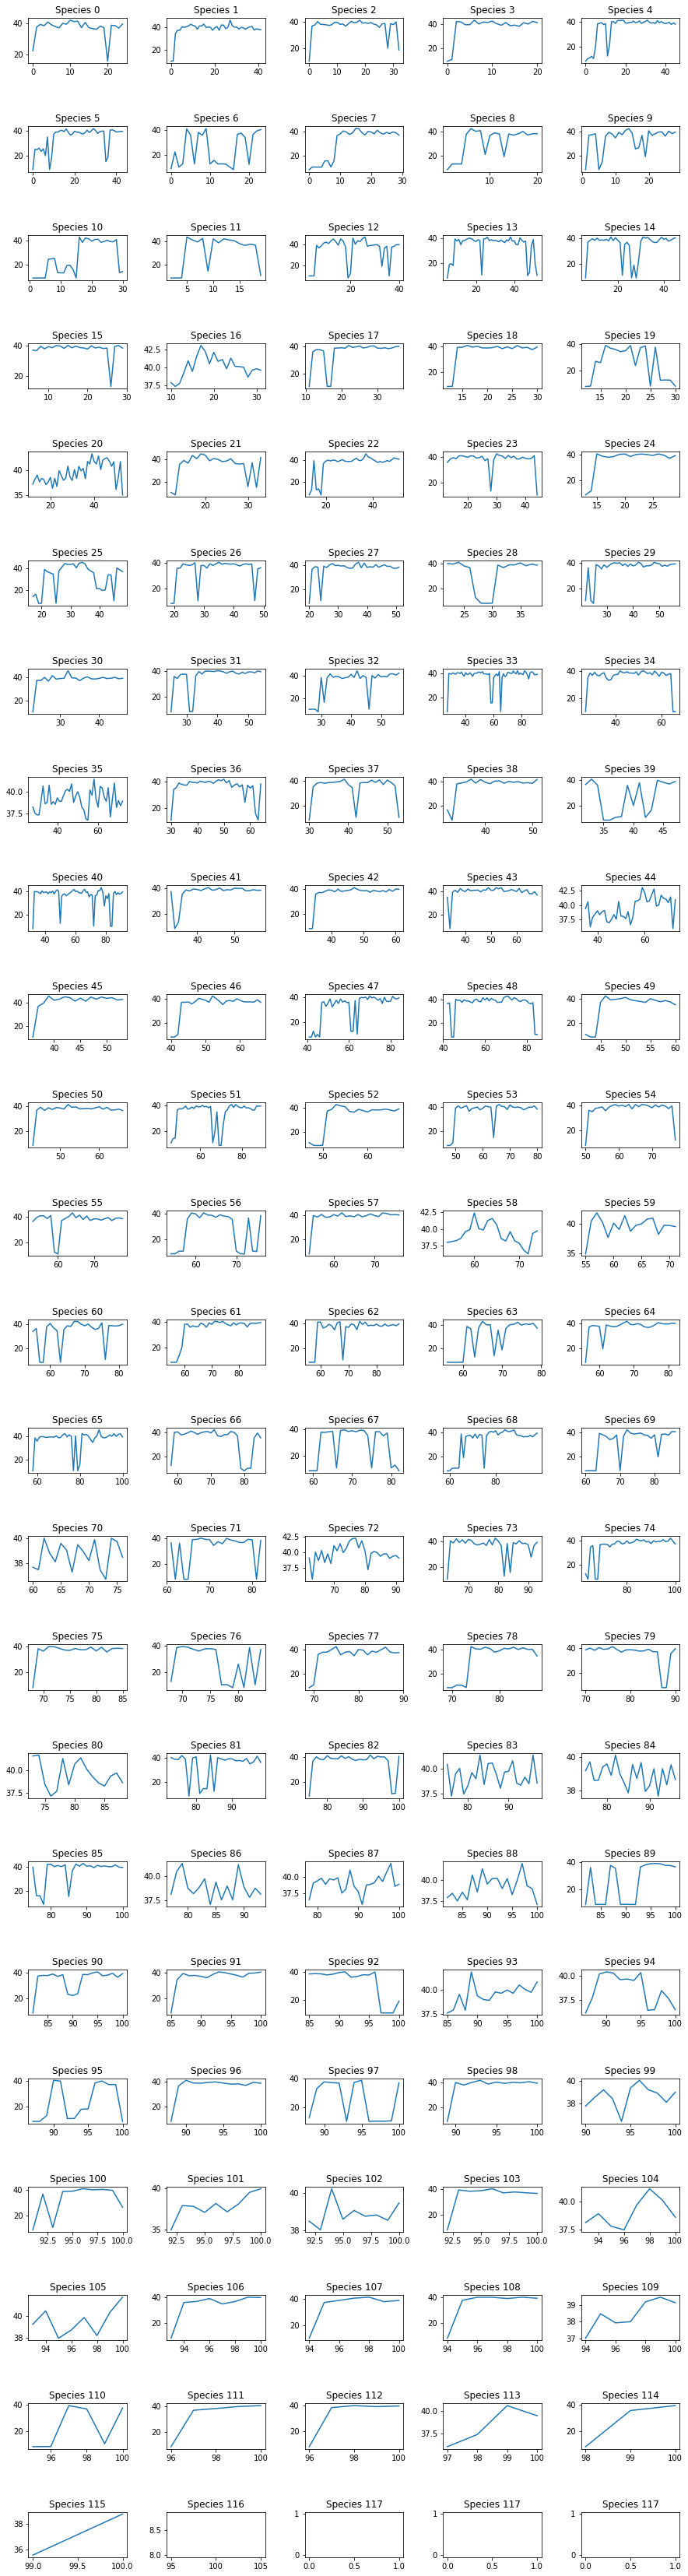

In [6]:
# Plot species fitness per generation
generations = [p.generation for p in populations]
species_sets = [p.species for p in populations]
species_keys = sorted(list(set(k for pop in populations for k in pop.species.species.keys())))

cols = 5
rows = int(len(species_keys) / cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(15, 60))
for r in range(rows):
    for c in range(cols):
        if species_keys:
            key = species_keys.pop(0)
            fitnesses = []
            generations = []
            for pop in populations:
                species = pop.species.species.get(key)
                if species:
                    generations.append(pop.generation)
                    fitnesses.append(species.fitness)
        
        axes[r, c].plot(generations, fitnesses)
        axes[r, c].set_title(f'Species {key}')
        
plt.subplots_adjust(wspace = 0.4, hspace = 1.4)
plt.show()

**Observations:**

* The species almost all reach 40 and then stagnate and become extinct.

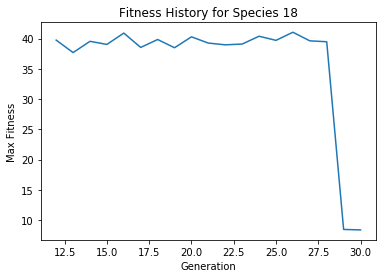

In [7]:
# A closer look at a species
key = 18
last_population = [p for p in populations if key in p.species.species][-1]
species = last_population.species.species[key]
generations = list(range(last_population.generation, last_population.generation - len(species.fitness_history), -1))

plt.plot(generations, species.fitness_history)
plt.title(f'Fitness History for Species {key}')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.show()

### Visualise Genomes

In [8]:
# Examine the best genomes for each species
best_genomes = {}

for pop in populations:
    for key, species in pop.species.species.items():
        for genome in species.members.values():
            if key not in best_genomes and genome.fitness:
                best_genomes[key] = genome
            elif genome.fitness and best_genomes[key].fitness < genome.fitness:
                best_genomes[key] = genome

In [9]:
def genome_to_networkx(genome):
    """Create a NetworkX graph from a genome.
    """
    graph = nx.DiGraph()
    graph.graph['edge'] = {'splines': 'curved'}  # graphviz
    
    # Add nodes to graph
    for key, gene in genome.nodes.items():
        graph.add_node(key,
                       type=gene.type,
                       bias=gene.bias,
                       activation=gene.activation,
                       label=f'{key}: {gene.bias:+.3f}')  # graphviz
        
    # Add edges to graph
    for key, gene in genome.connections.items():
        colour = 'green' if gene.expressed else 'red'
        graph.add_edge(gene.in_node,
                       gene.out_node,
                       weight=gene.weight,
                       expressed=gene.expressed,
                       color=colour,  # graphviz
                       label=f'{gene.weight:+.3f}')  # graphviz
        
    return graph

In [24]:
def pad(img, desired_size):
    """
    Pad a graphiz diagram to the desired size. 1:1 aspect ratio.
    """
    pad_left = (desired_size - img.shape[0]) // 2
    pad_right = desired_size - img.shape[0] - pad_left
    pad_top = (desired_size - img.shape[1]) // 2
    pad_bottom = desired_size - img.shape[1] - pad_top
    
    img = np.pad(img,
                 pad_width=((pad_left, pad_right), (pad_top, pad_bottom), (0, 0)),
                 mode='constant', constant_values=(255))
    
    return img

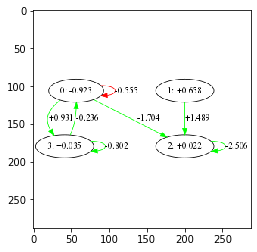

In [11]:
# Draw the best genome from Species 1 (using graphviz)
genome = best_genomes[1]
graph = genome_to_networkx(genome)
graph = nx.drawing.nx_agraph.to_agraph(graph)
graph.layout('dot')
graph.graph_attr['size'] = '3!'
graph.draw('graph.png')
img = Image.open('graph.png')
img = np.array(img)
img = pad(img, 288)
plt.imshow(img)
plt.show()

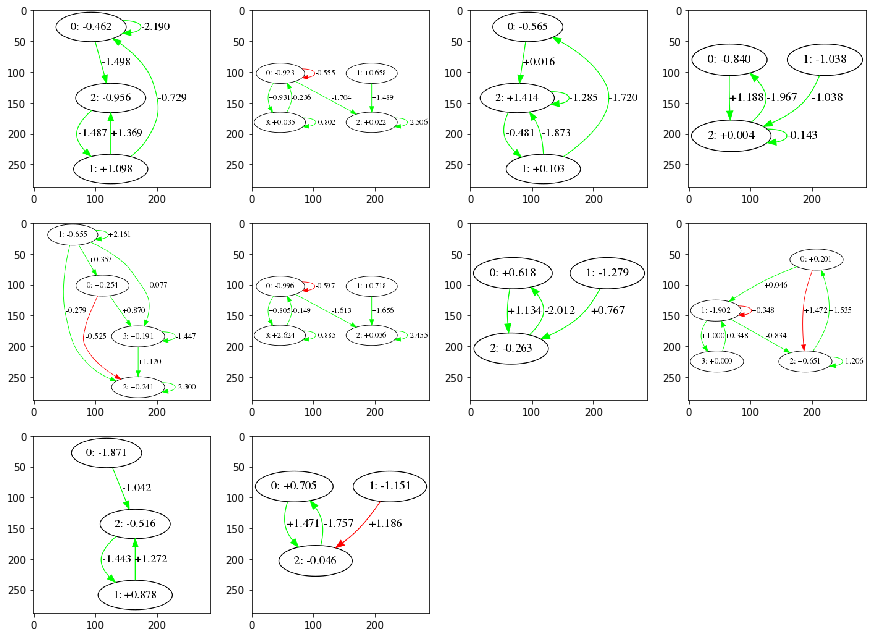

In [13]:
# Draw the best genomes for the first n species
n_subplots = 10 # len(best_genomes)
cols = 4
rows = n_subplots // cols + n_subplots % cols

plt_position = range(1, n_subplots + 1)

fig = plt.figure(1, figsize=(15, 15)) # (15, 60) when drawing all species
for k in range(n_subplots):
    genome = best_genomes[k]
    graph = genome_to_networkx(genome)
    
    ax = fig.add_subplot(rows, cols, plt_position[k])
    
    graph = nx.drawing.nx_agraph.to_agraph(graph)
    graph.graph_attr['size'] = '3!, 3!'
    graph.graph_attr['ratio'] = 'compress'
    graph.layout('dot')
    graph.draw('graph.png')
    
    # Pad image
    img = Image.open('graph.png')
    img = np.array(img)
    img = pad(img, 288)
    
    # Pad image
    img = np.array(img)
    
    plt.imshow(img)
    
plt.show()

### Analyse solution behaviour

In [17]:
SOLUTION_PATH = 'solution.pickle'
genome = pickle.load(open(SOLUTION_PATH, 'rb'))

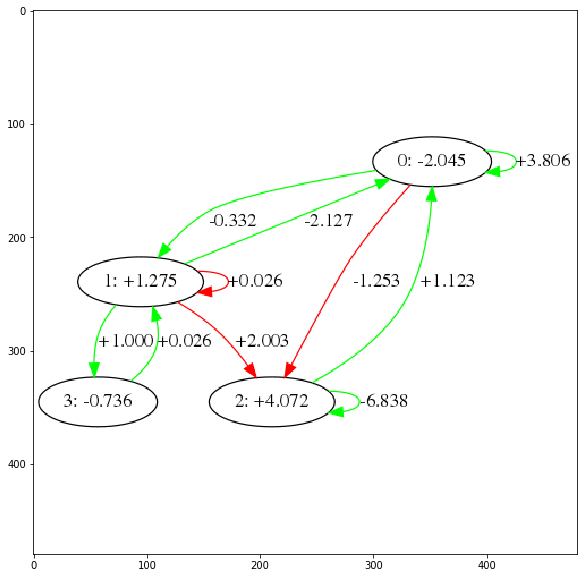

In [40]:
# Draw genome
graph = genome_to_networkx(genome)
graph = nx.drawing.nx_agraph.to_agraph(graph)
graph.layout('dot')
graph.graph_attr['size'] = '5!'
graph.draw('graph.png')
img = Image.open('graph.png')
img = np.array(img)
img = pad(img, 480)
plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.show()

In [42]:
# Create RNN
network = RNN.create(genome)

In [46]:
network.reset()
print(network.forward([-0.009121894957541987, 0.000584927323055338]))
print(network.forward([-0.008902051070661544, 0.0005637987062539645]))

[0.9999999985595094]
[9.82776038062648e-07]


In [47]:
network.reset()
print(network.forward([-0.008902051070661544, 0.0005637987062539645]))
print(network.forward([-0.009121894957541987, 0.000584927323055338]))

[0.9999999985595094]
[9.82776038062648e-07]


In [83]:
network.reset()
for i in range(10):
    print(network.forward([0, 0.0]))

[0.9999999985595094]
[9.82776038062648e-07]
[0.999999998559461]
[9.827760380642752e-07]
[0.999999998559461]
[9.827760380642752e-07]
[0.999999998559461]
[9.827760380642752e-07]
[0.999999998559461]
[9.827760380642752e-07]


In [82]:
print(network.forward([-0.909121894957541987, 0.900584927323055338]))

[9.827760380642752e-07]


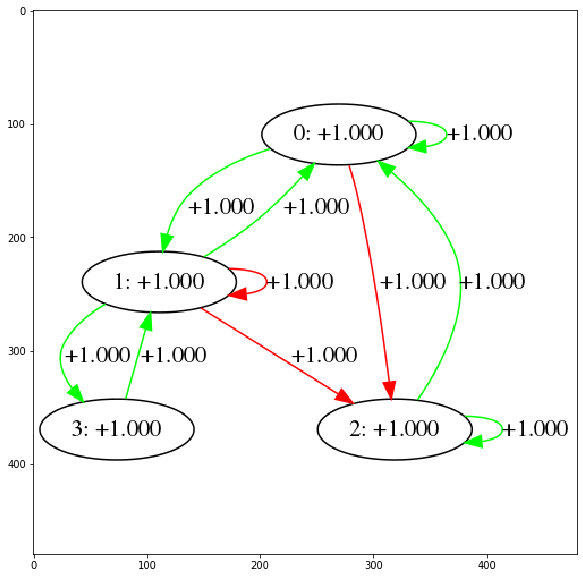

In [85]:
# Copy genome
genome_copy = genome.copy()

# Change weights
for g in genome_copy.nodes.values():
    g.bias = 1.0
for g in genome_copy.connections.values():
    g.weight = 1.0

# Draw genome
graph = genome_to_networkx(genome_copy)
graph = nx.drawing.nx_agraph.to_agraph(graph)
graph.layout('dot')
graph.graph_attr['size'] = '5!'
graph.draw('graph.png')
img = Image.open('graph.png')
img = np.array(img)
img = pad(img, 480)
plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.show()

In [101]:
network_copy = RNN.create(genome_copy)

In [106]:
network_copy.reset()
for i in range(15):
    print(network_copy.forward([0.0, 0.0]))

[0.9933071490757153]
[0.9999530572925]
[0.9999545914750366]
[0.9999545918233441]
[0.9999545918234232]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]
[0.9999545918234234]


In [109]:
neat.activations.sigmoid_activation(1)

0.9933071490757153

In [104]:
network_copy.node_evals

[(1, 1.0, <function neat.activations.sigmoid_activation(z)>, [(0, 1.0)]),
 (2, 1.0, <function neat.activations.sigmoid_activation(z)>, [(2, 1.0)]),
 (0,
  1.0,
  <function neat.activations.sigmoid_activation(z)>,
  [(2, 1.0), (1, 1.0), (0, 1.0)])]